In [2]:
import os
import sys

import json
import pickle

from pathlib import Path

import time, datetime
import math


import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels


import scipy
from scipy.stats import pearsonr, spearmanr
from scipy.stats import skew

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# pip install cesium
# conda install -c conda-forge cesium
# Cesium is an end-to-end machine learning platform for time-series, from calculation of features to model-building to predictions.
import cesium
from cesium import datasets
from cesium import featurize as ft

# conda install -c conda-forge xgboost
# conda install -c conda-forge xgboost== 0.80
import xgboost as xgb


# conda install -c anaconda mxnet
# conda install -c anaconda perf
import perf
import mxnet as mx


# conda install -c conda-forge hmmlearn
from hmmlearn.hmm import GaussianHMM


import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20, 6]
import matplotlib.pyplot as plt

mpl.style.use(['seaborn-whitegrid'])
print("Using style of 'seaborn-whitegrid' to plot")
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Using style of 'seaborn-whitegrid' to plot


In [2]:
%load_ext watermark
%watermark --iversions

cesium          0.9.12
pandas          1.0.3
numpy           1.18.4
xgboost         0.80
matplotlib      3.2.1
statsmodels.api 0.11.0
scipy           1.4.1
statsmodels     0.11.0
mxnet           1.5.0
sklearn         0.22.1
json            2.0.9



In [3]:
sys.stderr.write("***start***\n")

***start***


In [4]:
pwd

'/home/edison/Desktop/2019_Modern_TimeSeriesAnalysis'

In [5]:
folder = Path("/home/edison/Desktop/2019_Modern_TimeSeriesAnalysis/Data")
print(f'The data folder for this notebook is: {folder}')

The data folder for this notebook is: /home/edison/Desktop/2019_Modern_TimeSeriesAnalysis/Data


# **State Space Models** 
1. more of a exploratory tool for checking what's the dynamic behind the data
2. general idea is that we have a unobserved state behind the scenen and was presented with observed numbers in-front

## **1. Structural Time Series**

In [6]:
file_1 = folder / "global_temps.csv"
print(file_1)

/home/edison/Desktop/2019_Modern_TimeSeriesAnalysis/Data/global_temps.csv


In [7]:
df = pd.read_csv(file_1)

In [8]:
df.head(3)

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504


In [9]:
df.tail(3)

,Source,Date,Mean
3285,GISTEMP,1880-02-06,-0.2100
3286,GCAG,1880-01-06,0.0009
3287,GISTEMP,1880-01-06,-0.3000


In [10]:
df["Source"].unique()

array(['GCAG', 'GISTEMP'], dtype=object)

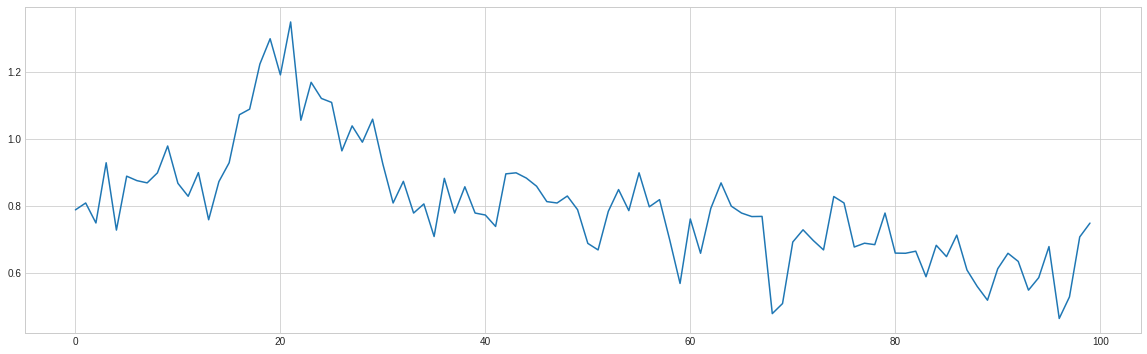

In [11]:
plt.figure(figsize = (20, 6))
plt.plot(df['Mean'][:100])
plt.show()

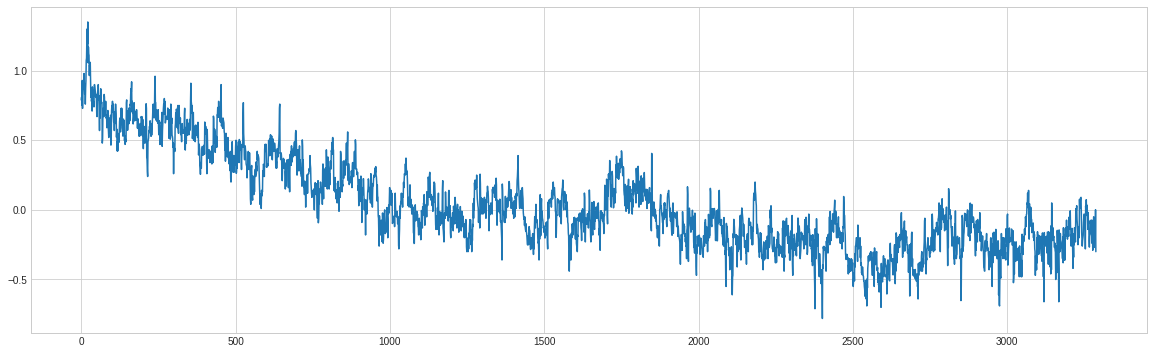

In [12]:
plt.figure(figsize = (20, 6))
plt.plot(df['Mean'])
plt.show()

2 problems above figures have:
1. time axis
2. 2 groups of data mixed together, makes it obnoxiuosly wrong, i.e, this is a global warming data from 2 data sources, above figure shows decline, not climbing

In [13]:
df = df.pivot_table(index='Date', columns='Source', values='Mean')

In [14]:
df.head(3)

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18


In [15]:
df.tail(3)

Source,GCAG,GISTEMP
Date,,
2016-10-06,0.7292,0.89
2016-11-06,0.7504,0.93
2016-12-06,0.7895,0.81


In [16]:
type(df.index)

pandas.core.indexes.base.Index

In [17]:
df.index = pd.to_datetime(df.index)

In [18]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [19]:
df.head(3)

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18


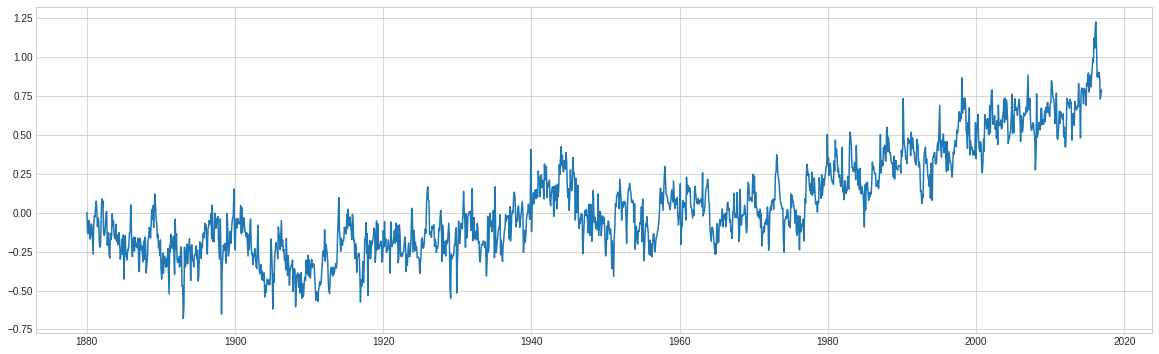

In [20]:
plt.figure(figsize = (20, 6))
plt.plot(df['GCAG'])
plt.show()

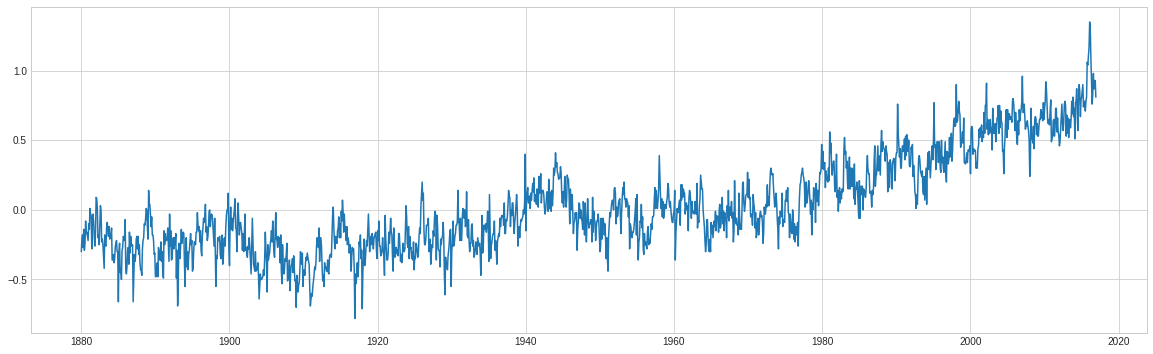

In [21]:
plt.figure(figsize = (20, 6))
plt.plot(df['GISTEMP'])
plt.show()

Now the figures make sense

#### How strongly do these measurements correlate contemporaneously?

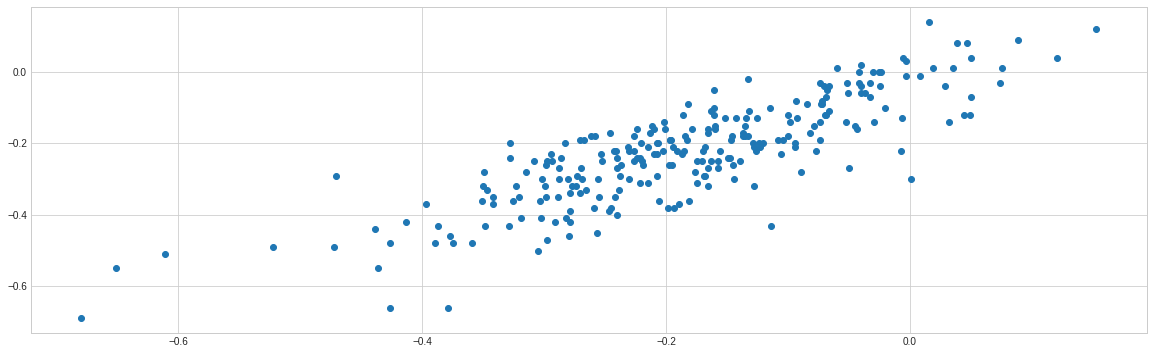

In [22]:
plt.figure(figsize = (20, 6))
plt.scatter(df['1880':'1900'][['GCAG']], 
            df['1880':'1900'][['GISTEMP']])
plt.show()

In [23]:
pearsonr(df['1880':'1899'].GCAG, df['1881':'1900'].GISTEMP)

(0.1546405732961276, 0.01650223473095511)

In [24]:
min(df.index)

Timestamp('1880-01-06 00:00:00')

In [25]:
max(df.index)

Timestamp('2016-12-06 00:00:00')

## **Unobserved component model**

In [26]:
train = df['1960':]

In [27]:
train.head(3)

Source,GCAG,GISTEMP
Date,,
1960-01-06,0.0032,-0.01
1960-02-06,0.1858,0.14
1960-03-06,-0.2041,-0.36


https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html

In [28]:
# smooth trend model without seasonal or cyclical components specified
model = {
    'level': 'smooth trend', 'cycle': False, 'seasonal': None, 
        }

In [29]:
gcag_model = sm.tsa.UnobservedComponents(train['GCAG'], **model)
gcag_res = gcag_model.fit()

/home/edison/anaconda3/envs/myenv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


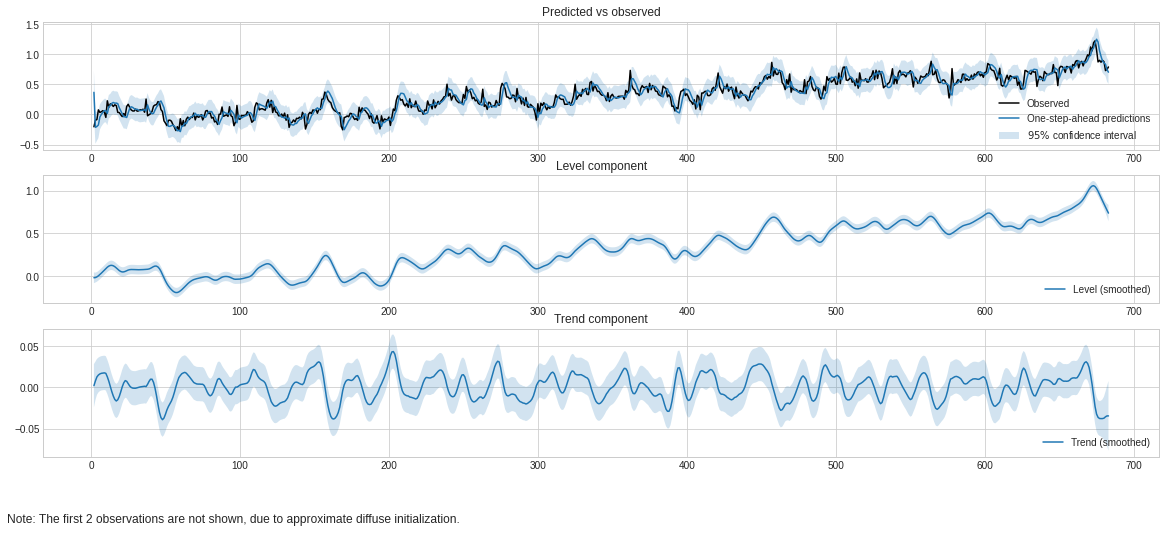

In [30]:
fig = gcag_res.plot_components(legend_loc='lower right', figsize=(20, 8));

In [31]:
# Perform rolling prediction and multistep forecast

num_steps = 20
predict_res = gcag_res.get_prediction(dynamic = train['GCAG'].shape[0] - num_steps)

predict = predict_res.predicted_mean

ci = predict_res.conf_int()

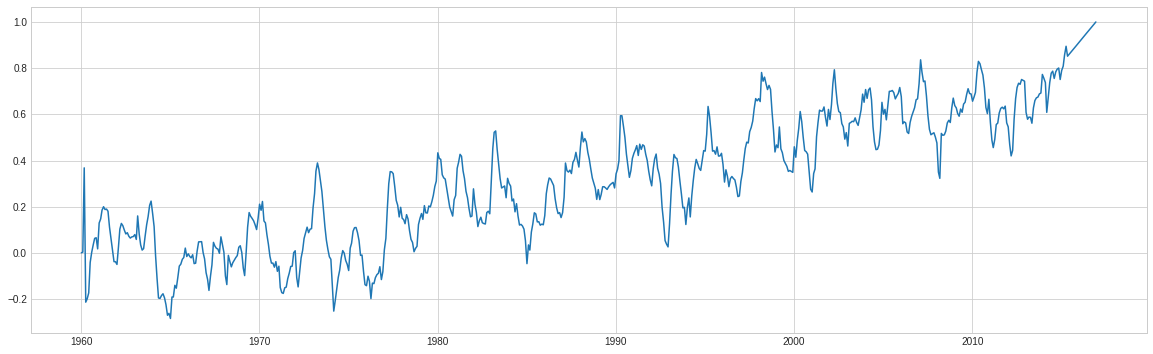

In [32]:
plt.figure(figsize = (20, 6))
plt.plot(predict)
plt.show()

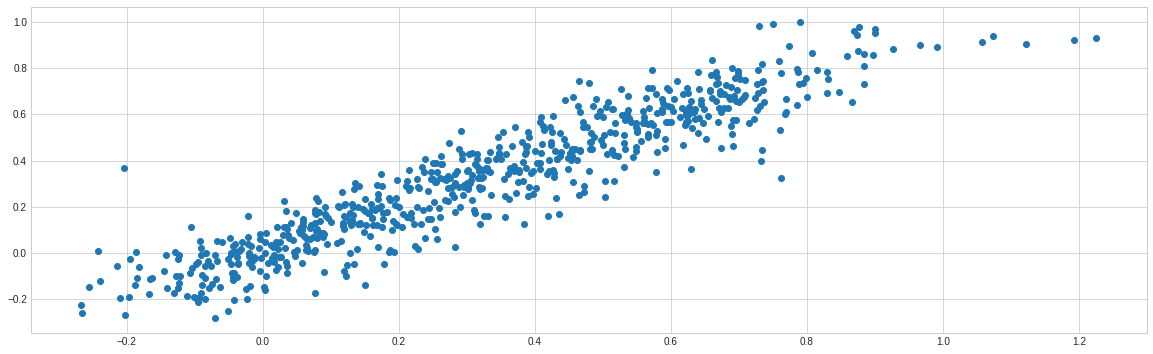

In [33]:
plt.figure(figsize = (20, 6))
plt.scatter(train['GCAG'], predict)
plt.show()

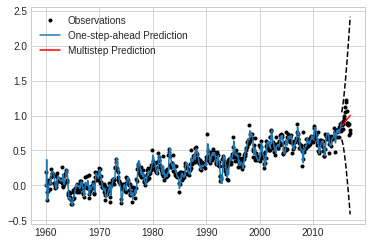

In [34]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train['GCAG'], 'k.', label='Observations');
ax.plot(train.index[:-num_steps], predict[:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

plt.show()

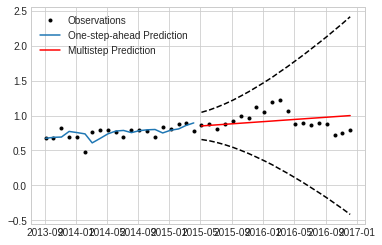

In [35]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train.index[-40:], train['GCAG'][-40:], 'k.', label='Observations');
ax.plot(train.index[-40:-num_steps], predict[-40:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');

In [36]:
# Now train a model with 12-month seasonality
seasonal_model = {
    'level': 'local linear trend',
    'seasonal': 12
}
mod = sm.tsa.UnobservedComponents(train['GCAG'], **seasonal_model)
res = mod.fit(method='powell', disp=False)

/home/edison/anaconda3/envs/myenv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


/home/edison/anaconda3/envs/myenv/lib/python3.6/site-packages/statsmodels/tsa/statespace/structural.py:1723: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])
/home/edison/anaconda3/envs/myenv/lib/python3.6/site-packages/statsmodels/tsa/statespace/structural.py:1723: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])
/home/edison/anaconda3/envs/myenv/lib/python3.6/site-packages/statsmodels/tsa/statespace/structural.py:1723: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


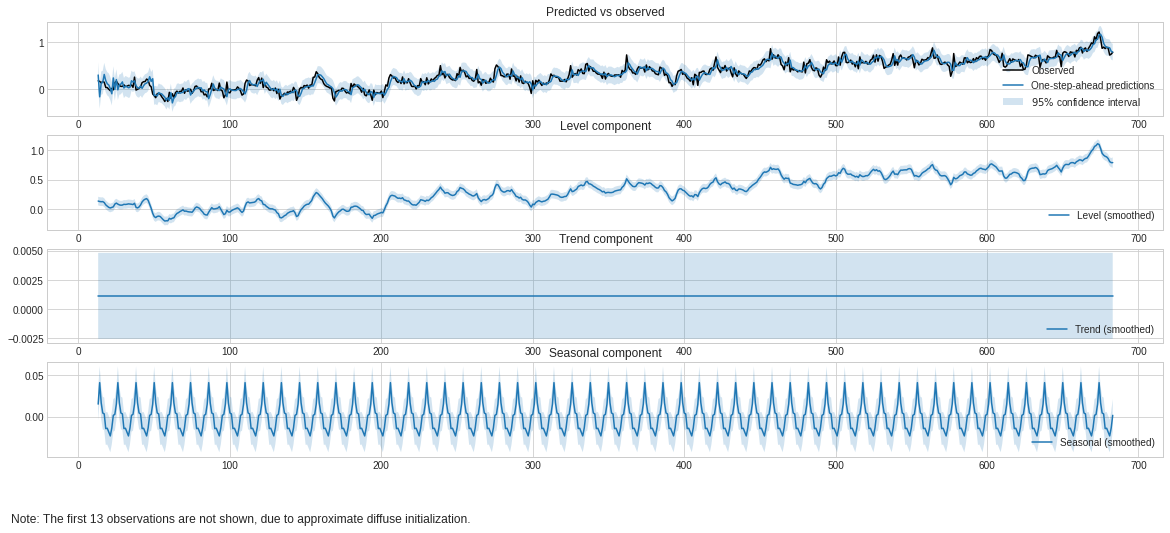

In [37]:
fig = res.plot_components(legend_loc='lower right', figsize=(20, 8));

#### How does this compare to the original model?

In [38]:
pearsonr(gcag_res.predict(), train['GCAG'])

(0.9376554633519252, 3.16460221e-315)

In [39]:
pearsonr(res.predict(), train['GCAG'])

(0.9443196682706657, 0.0)

In [40]:
np.mean(np.abs(gcag_res.predict() - train['GCAG']))

0.07721215185722816

In [41]:
np.mean(np.abs(res.predict() - train['GCAG']))

0.07203435215679338

In [42]:
# Now train a model with local level
seasonal_model = {
    'level': 'local level',
    'seasonal': 12
}
llmod = sm.tsa.UnobservedComponents(train['GCAG'], **seasonal_model)
ll_level_res = llmod.fit(method='powell', disp=False)

/home/edison/anaconda3/envs/myenv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


/home/edison/anaconda3/envs/myenv/lib/python3.6/site-packages/statsmodels/tsa/statespace/structural.py:1723: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])
/home/edison/anaconda3/envs/myenv/lib/python3.6/site-packages/statsmodels/tsa/statespace/structural.py:1723: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


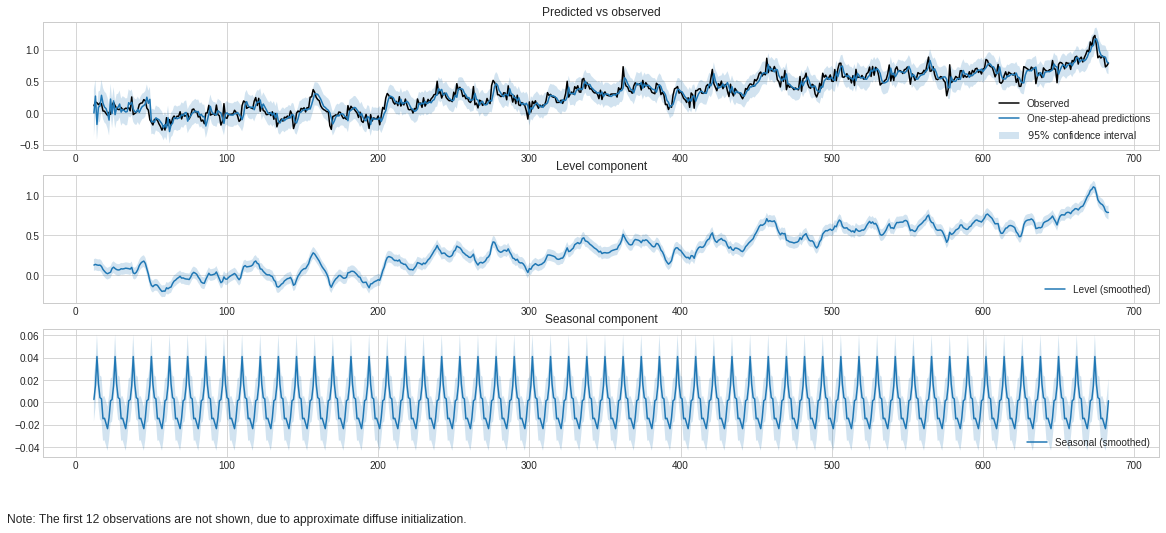

In [43]:
fig = ll_level_res.plot_components(legend_loc='lower right', figsize=(20, 8));

In [44]:
np.mean(np.abs(ll_level_res.predict() - train['GCAG']))

0.07157737862671665

#### a common null model for time series is to predict the value at time t-1 for the value at time t. How does such a model compare to the models we fit here?

In [45]:
pearsonr(ll_level_res.predict(), train['GCAG'])

(0.9450048071803737, 0.0)

In [46]:
pearsonr(train['GCAG'].iloc[:-1, ], train['GCAG'].iloc[1:, ])

(0.9403611903118237, 4.01e-321)

In [47]:
np.mean(np.abs(ll_level_res.predict() - train['GCAG']))

0.07157737862671665

In [48]:
np.mean(np.abs(train['GCAG'].iloc[:-1, ].values, train['GCAG'].iloc[1:, ].values))

0.3475446559297218

## **2. HMM**
1. the HMM differs from traditional methods such as ARIMA: in HMM, don't need whole historical data, if we have t-1 point, we already assume we're good enough to have all info we need up till now
2. automatic regime switching
3. non-linear can be done, ARIMA cannot
3. parameter estimation: Baum-Welch algorithm
4. smoothing/state labeling: Viterbi algo
5. always get a local maximum point, but may not a global point
6. might over-fit like structural TS model

In [49]:
file_2 = folder / "Nile.csv"
print(file_2)

/home/edison/Desktop/2019_Modern_TimeSeriesAnalysis/Data/Nile.csv


In [50]:
nile = pd.read_csv(file_2, index_col = 0)

In [51]:
nile.head(3)

,year,val
1,1871,1120
2,1872,1160
3,1873,963


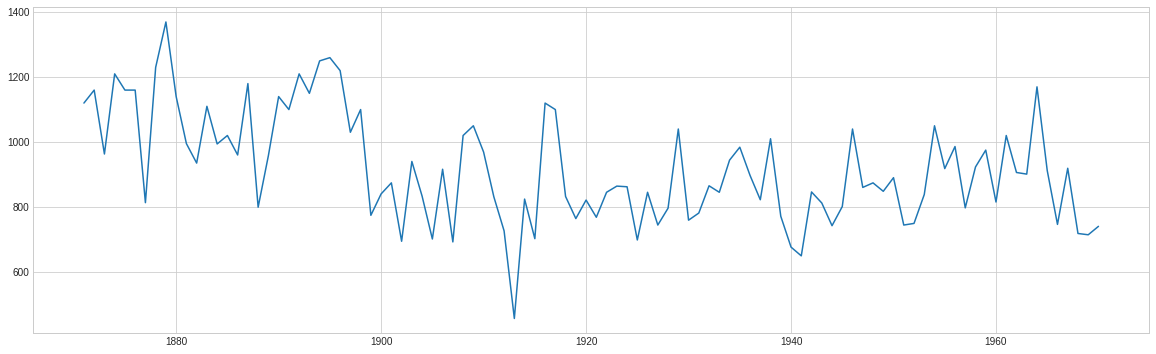

In [52]:
plt.figure(figsize = (20, 6))
plt.plot(nile['year'], nile['val'])
plt.show()

In [53]:
from hmmlearn.hmm import GaussianHMM
def fitHMM(vals, n_states):
    vals = np.reshape(vals,[len(vals),1])
    
    # fit Gaussian HMM to Q
    model = GaussianHMM(n_components=n_states, n_iter=100).fit(vals)
     
    # classify each observation as state 0 or 1
    hidden_states = model.predict(vals)
 
    # fit HMM parameters
    mus = np.squeeze(model.means_)
    sigmas = np.squeeze(np.sqrt(model.covars_))
    transmat = np.array(model.transmat_)
    print(mus)
    print(sigmas)
    # re-order parameters in ascending order of mean of underlying distribution
    idx      = np.argsort(mus)
    mus      = mus[idx]
    sigmas   = sigmas[idx]
    transmat = transmat[idx, :][:, idx]
    
    state_dict = {}
    states = [i for i in range(n_states)]
    for i in idx:
        state_dict[i] = states[idx[i]]
    
    relabeled_states = [state_dict[h] for h in hidden_states]
    return (relabeled_states, mus, sigmas, transmat, model)

In [54]:
hidden_states, mus, sigmas, transmat, model = fitHMM(nile.val.values, 3)

[1097.27279934  796.01723512  884.82315224]
[133.03503832  67.16297958 138.785672  ]


In [55]:
def plot_states(ts_vals, states, time_vals):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Year)')
    ax1.set_ylabel('Nile river flow',         color=color)
    ax1.plot(time_vals, ts_vals,      color=color)
    ax1.tick_params(axis='y',            labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Hidden state', color=color)  
    ax2.plot(time_vals,states,     color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()

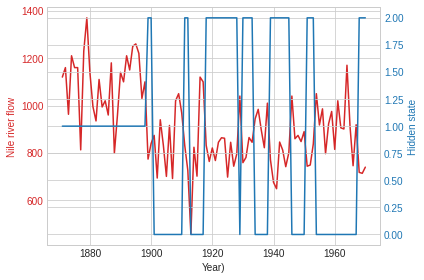

In [56]:
plot_states(nile['val'], hidden_states, nile['year'])

In [57]:
hidden_states, mus, sigmas, transmat, model = fitHMM(nile.val.values, 3)            # specify 3 hidden states

[1097.27216026  796.06732375  884.87213564]
[133.0357056   67.19550566 138.81884828]


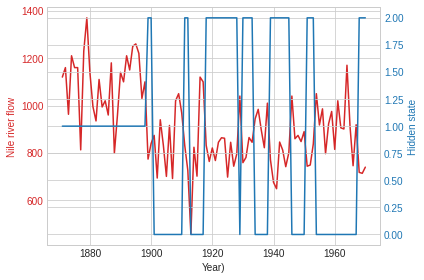

In [58]:
plot_states(nile['val'], hidden_states, nile['year'])

In [59]:
mus

array([ 796.06732375,  884.87213564, 1097.27216026])

In [60]:
np.set_printoptions(precision = 3, suppress = True)

In [61]:
transmat

array([[0.508, 0.492, 0.   ],
       [0.305, 0.695, 0.   ],
       [0.036, 0.   , 0.964]])

In [62]:
mus

array([ 796.067,  884.872, 1097.272])

# **Machine Learning Models**

When using machine learning algorithms for time series, there are no such a framework you can just feed your time data and let algo work, typically, ppl will do feature generation for each series of data, i.e.: mean, median, min, max, # of peaks, etc., and then make that list of values a point for one series, we do it for each series and get a generated data to perform algo

check **catch 22 canonical set** project for TS feature generation

After we had our generated data ready, we can do tasks as:
1. classification: http://www.timeseriesclassification.com/description.php?Dataset=Crop (trees or RF or xgboost(which is very good in daily applications recent yrs))
2. clustring: https://developers.google.com/machine-learning/clustering/interpret & https://www.semanticscholar.org/paper/1-Characteristic-based-Clustering-for-Time-Series/0a5e8d1390f3ceb851f4a37a7ec8edb95e05f698 & http://ofdataandscience.blogspot.com/2013/03/capital-bikeshare-time-series-clustering.html
3. for time series clustring, Euclidean distance is bad, don't use it, instead, ues Dynamic Time Warping: https://en.wikipedia.org/wiki/Dynamic_time_warping

## **Classification by feature generation using cesium**

http://cesium-ml.org/docs/auto_examples/plot_EEG_Example.html

In [63]:
eeg = datasets.fetch_andrzejak()

Loaded data from cached archive.


In [66]:
with open('eeg.pkl', 'wb') as file:
    pickle.dump(eeg, file)

In [67]:
with open('eeg.pkl','rb') as read_obj:
    eeg = pickle.load(read_obj)

In [68]:
type(eeg)

dict

In [69]:
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

In [70]:
eeg["classes"]

array(['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z',
       'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

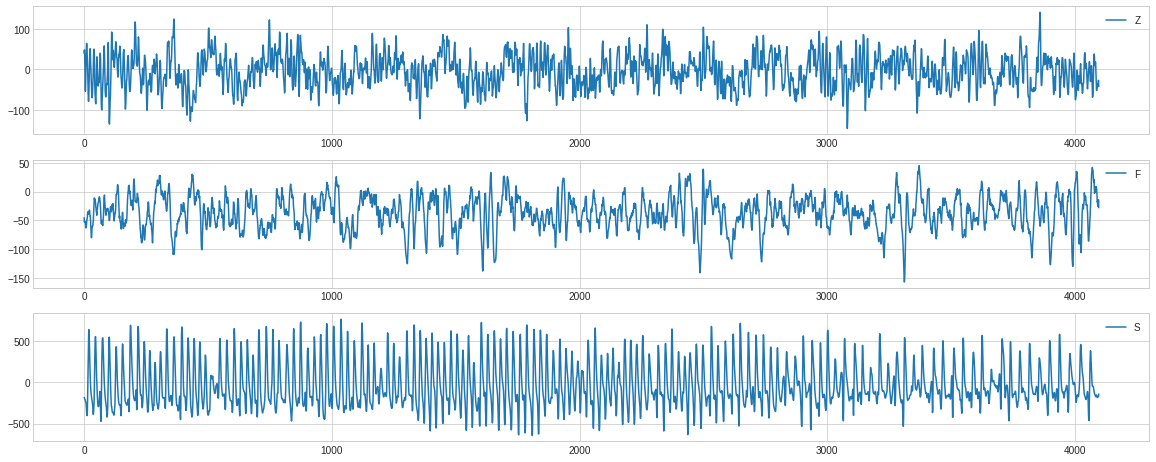

In [71]:
plt.figure(figsize = (20, 8))

plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg['classes'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg['classes'][300])
plt.subplot(3, 1, 3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg['classes'][450])

plt.show()

In [72]:
type(eeg["measurements"][0])

numpy.ndarray

In [73]:
type(eeg['measurements'])

list

In [74]:
len(eeg['measurements'])

500

In [75]:
eeg['measurements'][0].shape

(4097,)

In [76]:
# fFeature generation:

 features_to_use = ["amplitude",
                    "percent_beyond_1_std",
                    "percent_close_to_median",
                   "skew",
                   "max_slope"]
 fset_cesium = ft.featurize_time_series(times=eeg["times"],
                                               values=eeg["measurements"],
                                               errors=None,
                                               features_to_use=features_to_use,
                                              scheduler = None)

In [77]:
fset_cesium_2 = pd.read_csv("full_eeg_data_features.csv", header = [0, 1])

In [78]:
fset_cesium_2.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
,channel,0,0,0,0,0
0,0,143.5,0.327313,0.505004,0.032805,11107.796610
1,1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,3,171.5,0.300952,0.541128,0.063678,17008.813559
4,4,170.0,0.305101,0.566268,0.142753,13016.949153


In [79]:
fset_cesium_2.index

RangeIndex(start=0, stop=500, step=1)

In [80]:
fset_cesium_2.shape

(500, 6)

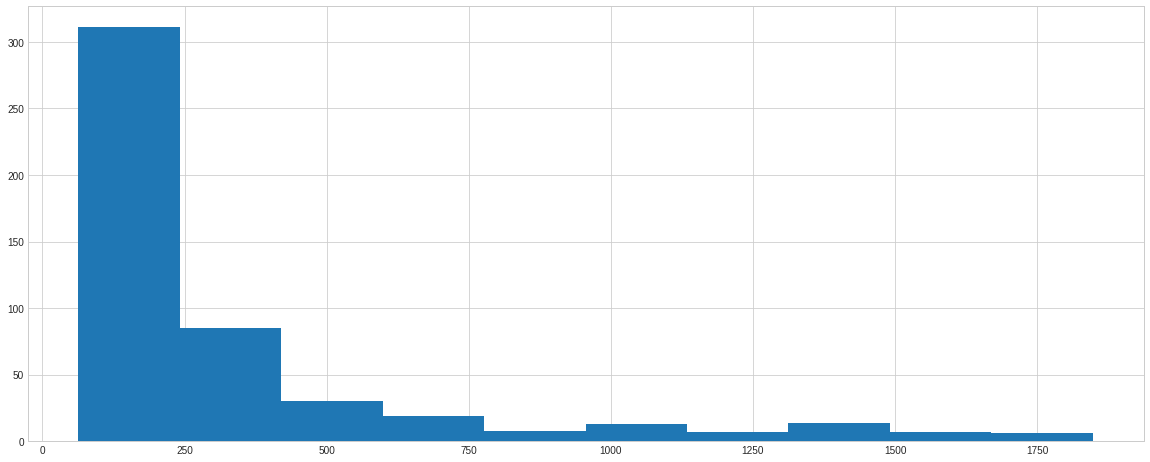

In [81]:
plt.figure(figsize = (20, 8))
plt.hist(fset_cesium_2.iloc[:, 1])
plt.show()

In [82]:
fset_cesium_2['classes'] = eeg['classes']
fset_cesium_2.columns = fset_cesium_2.columns.droplevel(-1)

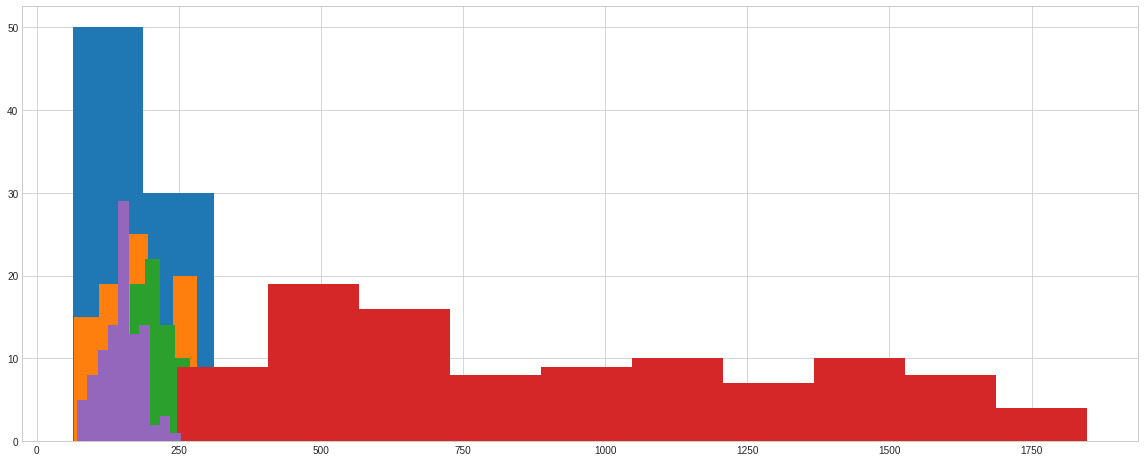

In [83]:
plt.figure(figsize = (20, 8))
fset_cesium_2.groupby('classes')['amplitude'].hist()
plt.show()

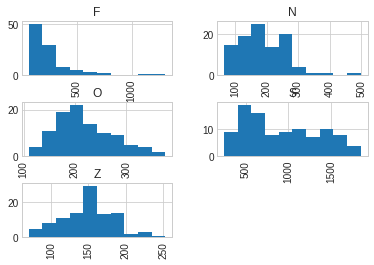

In [84]:
fset_cesium_2['amplitude'].hist(by=fset_cesium_2['classes'])
plt.show()

In [85]:
# train-test split:

X_train, X_test, y_train, y_test = train_test_split(
     fset_cesium_2.iloc[:, 1:6].values, eeg["classes"], random_state=21)

In [86]:
y_test

array(['O', 'S', 'N', 'F', 'S', 'S', 'Z', 'S', 'O', 'Z', 'F', 'O', 'S',
       'F', 'Z', 'N', 'Z', 'O', 'Z', 'Z', 'S', 'F', 'O', 'N', 'F', 'F',
       'Z', 'N', 'Z', 'N', 'S', 'Z', 'O', 'O', 'S', 'S', 'N', 'S', 'N',
       'S', 'N', 'O', 'N', 'S', 'Z', 'N', 'O', 'Z', 'Z', 'S', 'O', 'Z',
       'F', 'F', 'S', 'Z', 'N', 'O', 'N', 'F', 'Z', 'Z', 'N', 'Z', 'F',
       'Z', 'N', 'F', 'O', 'N', 'N', 'Z', 'N', 'O', 'N', 'F', 'O', 'F',
       'F', 'Z', 'S', 'N', 'Z', 'N', 'O', 'N', 'S', 'N', 'S', 'O', 'O',
       'S', 'O', 'N', 'N', 'S', 'N', 'S', 'Z', 'Z', 'S', 'S', 'O', 'F',
       'S', 'F', 'F', 'Z', 'F', 'Z', 'O', 'O', 'S', 'Z', 'Z', 'F', 'N',
       'Z', 'Z', 'F', 'S', 'N', 'Z', 'N', 'N'], dtype='<U1')

In [87]:
# RF clf
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=3,
                                random_state=21)

In [88]:
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [89]:
clf_rf.score(X_train, y_train)

0.6266666666666667

In [90]:
clf_rf.score(X_test, y_test)

0.616

In [91]:
np.unique(y_test, return_counts = True)

(array(['F', 'N', 'O', 'S', 'Z'], dtype='<U1'), array([20, 29, 21, 25, 30]))

In [92]:
y_test.shape

(125,)

In [93]:
y_train.shape

(375,)

In [94]:
# xgboost  --> very good fit

model = xgb.XGBClassifier(n_estimators=10, max_depth=3,
                              random_state=21)

In [95]:
model.fit(X_train, y_train)          # kernel dead when doing xgboost, need to downgrade to xgboost == 0.8

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
              n_jobs=1, nthread=None, objective='multi:softprob',
              random_state=21, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [96]:
model.score(X_test, y_test)

0.648

In [97]:
model.score(X_train, y_train)                 # --> very good fit

0.752

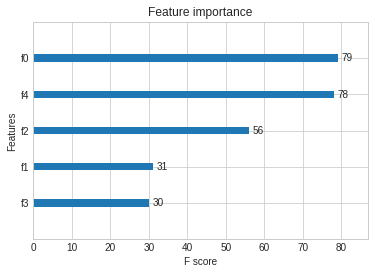

In [98]:
xgb.plot_importance(model)

#### Forecast with Decision Trees:

In [99]:
file_3 = folder / "AirPassengers.csv"
print(file_3)

/home/edison/Desktop/2019_Modern_TimeSeriesAnalysis/Data/AirPassengers.csv


In [100]:
ap = pd.read_csv(file_3)
ap.set_index('Month', inplace=True)

In [101]:
ap.head(3)

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132


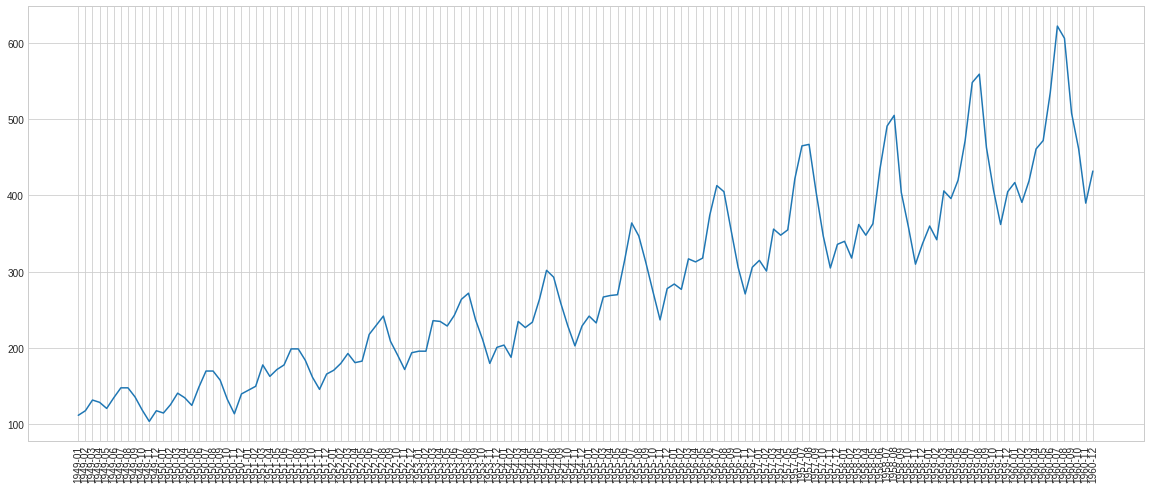

In [102]:
plt.figure(figsize = (20, 8))
plt.plot(ap)
plt.xticks(rotation = 'vertical')
plt.show()

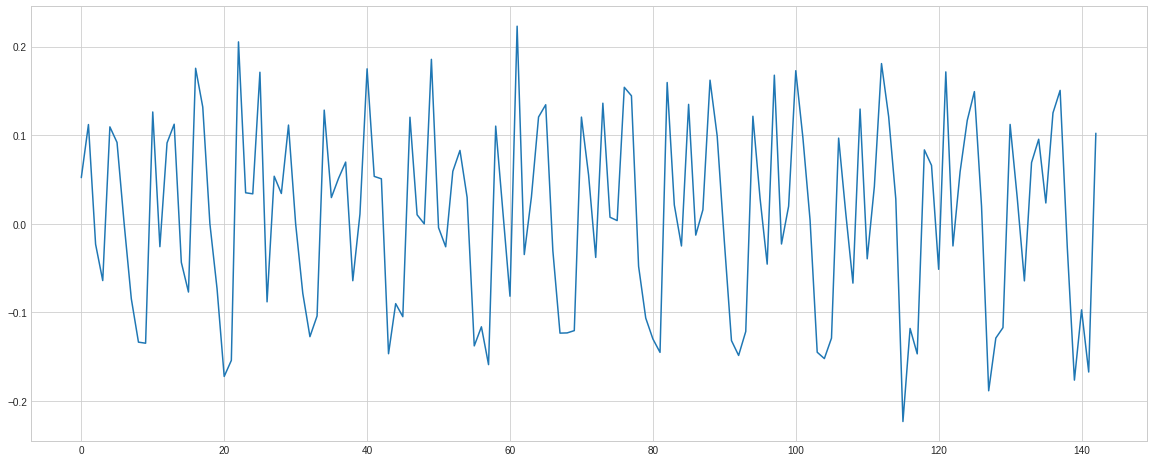

In [103]:
plt.figure(figsize = (20, 8))
plt.plot(np.diff(np.log(ap.values[:, 0])))
plt.show()

In Statistical(e.g., ARIMA) or State Space models, we need temporal horizon which is long time axis, in machine learning TS, we can't let algo aware of the time component, so we diff the data and chop off certain blocks to have different point sample one by one from a single series. For multiple series, we can do what we did before as to have each series a sample or even chop off each series into sub-samples and then form a whole sample.

In [104]:
ts = np.diff(np.log(ap.values[:, 0]))
ts.shape

(143,)

In [109]:
# 1 time series convert to many samples

In [110]:
NSTEPS = 12

In [111]:
vals = np.hstack([np.expand_dims(np.array(ts, dtype = np.float32), axis = 1) for _ in range(NSTEPS )])

In [112]:
vals.shape

(143, 12)

In [113]:
nrow = vals.shape[0]
for lag in range(1, vals.shape[1]):
    vals[:(nrow - lag),lag] = vals[lag:,lag]
    vals[(nrow - lag):, lag] = np.nan

In [114]:
vals

array([[ 0.052,  0.112, -0.023, ..., -0.135,  0.126, -0.026],
       [ 0.112, -0.023, -0.064, ...,  0.126, -0.026,  0.091],
       [-0.023, -0.064,  0.109, ..., -0.026,  0.091,  0.112],
       ...,
       [-0.097, -0.167,  0.102, ...,    nan,    nan,    nan],
       [-0.167,  0.102,    nan, ...,    nan,    nan,    nan],
       [ 0.102,    nan,    nan, ...,    nan,    nan,    nan]],
      dtype=float32)

In [115]:
vals = vals[:(vals.shape[0] - NSTEPS + 1), :]

In [116]:
vals.shape

(132, 12)

In [117]:
vals[-1]

array([ 0.029, -0.064,  0.069,  0.096,  0.024,  0.125,  0.151, -0.026,
       -0.176, -0.097, -0.167,  0.102], dtype=float32)

In [118]:
vals[-2]                                                                 # overlapping with vals[-1]

array([ 0.112,  0.029, -0.064,  0.069,  0.096,  0.024,  0.125,  0.151,
       -0.026, -0.176, -0.097, -0.167], dtype=float32)

In [119]:
ts[-NSTEPS:]                                                             # indeed same as vals[-1]

array([ 0.029, -0.064,  0.069,  0.096,  0.024,  0.125,  0.151, -0.026,
       -0.176, -0.097, -0.167,  0.102])

In [120]:
# featurize

In [121]:
measures = [vals[i][0:(NSTEPS - 1)] for i in range(vals.shape[0])]

In [122]:
times = [[j for j in range(NSTEPS - 1)] for i in range(vals.shape[0])]

In [123]:
measures[0]

array([ 0.052,  0.112, -0.023, -0.064,  0.109,  0.092,  0.   , -0.085,
       -0.134, -0.135,  0.126], dtype=float32)

In [124]:
len(measures[0])

11

In [125]:
features_to_use = [
                   "amplitude",
                   "percent_beyond_1_std",
                   "skew",
                   "max_slope",
                   "percent_amplitude"]
fset_ap = ft.featurize_time_series(times=times,
                                    values=measures,
                                    errors=None,
                                    features_to_use=features_to_use,
                                    scheduler = None)

In [126]:
fset_ap.columns = fset_ap.columns.droplevel(-1)

In [127]:
fset_ap.head()                                                           # 

feature,amplitude,percent_beyond_1_std,skew,max_slope,percent_amplitude
0,0.130513,0.454545,-0.155365,0.261026,0.132121
1,0.130513,0.545455,0.051772,0.261026,0.128461
2,0.130513,0.545455,0.037850,0.261026,0.128461
3,0.130513,0.454545,-0.192651,0.261026,0.132121
4,0.130513,0.454545,-0.233966,0.261026,0.132121


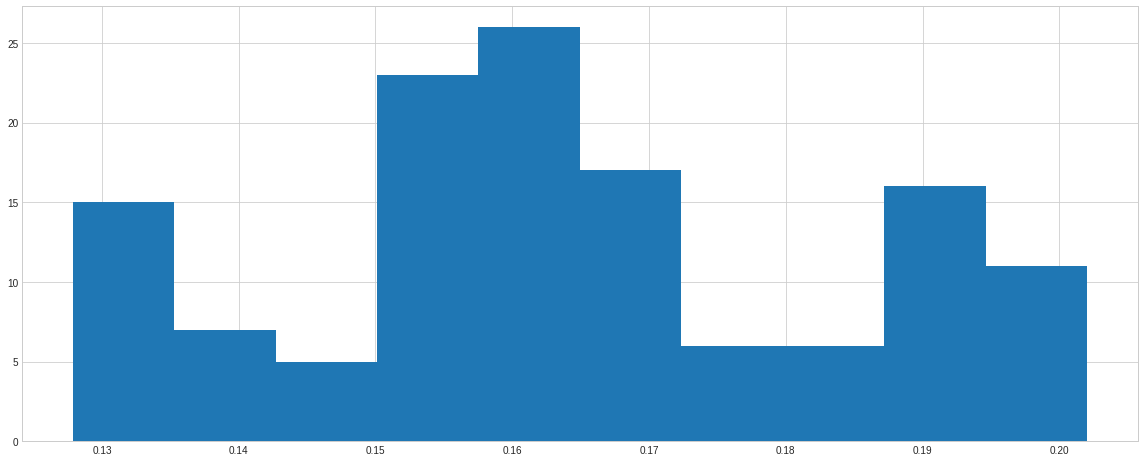

In [128]:
plt.figure(figsize = (20, 8))
plt.hist(fset_ap.amplitude)                             # multi-modal
plt.show()

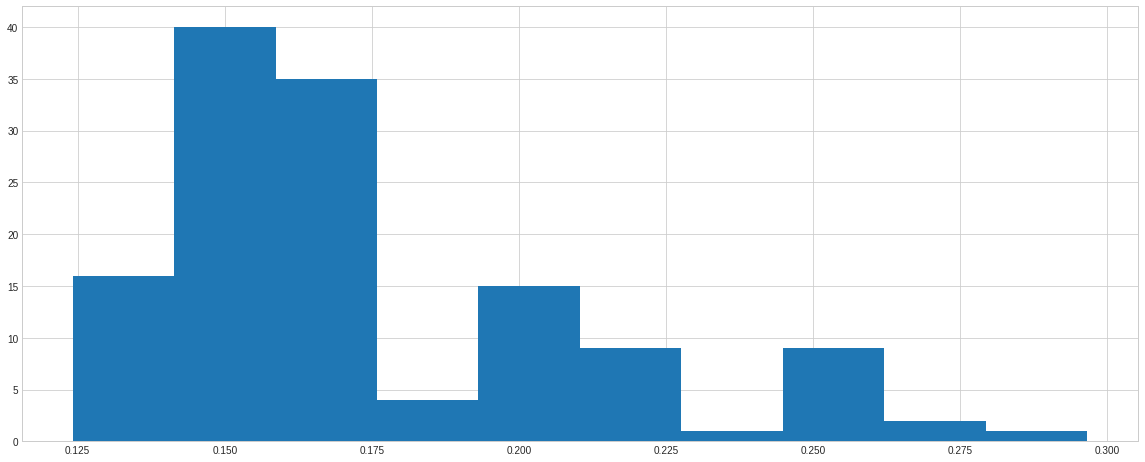

In [129]:
plt.figure(figsize = (20, 8))
plt.hist(fset_ap.percent_amplitude)
plt.show()

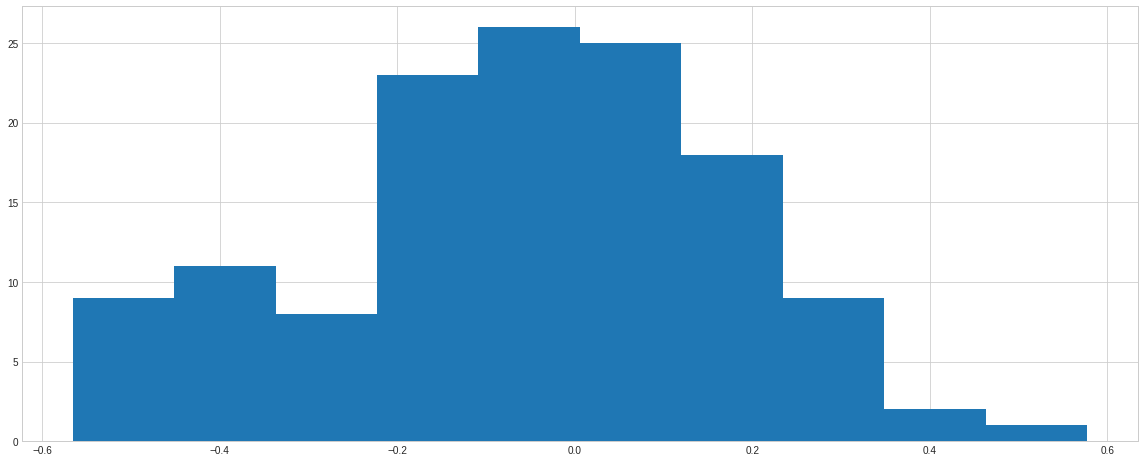

In [130]:
plt.figure(figsize = (20, 8))
plt.hist(fset_ap['skew'])
plt.show()

In [131]:
# first XGBRegressor?

In [132]:
outcomes = vals[:, -1]
outcomes

array([-0.026,  0.091,  0.112, -0.043, -0.077,  0.176,  0.132,  0.   ,
       -0.073, -0.172, -0.154,  0.205,  0.035,  0.034,  0.171, -0.088,
        0.054,  0.034,  0.112,  0.   , -0.078, -0.127, -0.104,  0.128,
        0.03 ,  0.051,  0.07 , -0.064,  0.011,  0.175,  0.054,  0.051,
       -0.147, -0.09 , -0.105,  0.12 ,  0.01 ,  0.   ,  0.186, -0.004,
       -0.026,  0.059,  0.083,  0.03 , -0.138, -0.116, -0.159,  0.11 ,
        0.015, -0.082,  0.223, -0.035,  0.03 ,  0.121,  0.134, -0.03 ,
       -0.123, -0.123, -0.121,  0.121,  0.055, -0.038,  0.136,  0.007,
        0.004,  0.154,  0.145, -0.048, -0.106, -0.13 , -0.145,  0.16 ,
        0.021, -0.025,  0.135, -0.013,  0.016,  0.162,  0.099, -0.02 ,
       -0.132, -0.149, -0.121,  0.121,  0.029, -0.045,  0.168, -0.023,
        0.02 ,  0.173,  0.097,  0.004, -0.145, -0.152, -0.129,  0.097,
        0.012, -0.067,  0.13 , -0.039,  0.042,  0.181,  0.121,  0.028,
       -0.223, -0.118, -0.147,  0.084,  0.066, -0.051,  0.172, -0.025,
      

In [133]:
X_train, y_train = fset_ap.iloc[:100, :], outcomes[:100]
X_test, y_test   = fset_ap.iloc[100:, :], outcomes[100:]

In [134]:
X_train.shape

(100, 5)

In [135]:
model = xgb.XGBRegressor(n_estimators=20, max_depth=2,
                              random_state=21)

In [136]:
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.467759
[1]	validation_0-rmse:0.425064
[2]	validation_0-rmse:0.386848
[3]	validation_0-rmse:0.35241
[4]	validation_0-rmse:0.321675
[5]	validation_0-rmse:0.294493
[6]	validation_0-rmse:0.270009
[7]	validation_0-rmse:0.248279
[8]	validation_0-rmse:0.235445
[9]	validation_0-rmse:0.218315
[10]	validation_0-rmse:0.208481
[11]	validation_0-rmse:0.195013
[12]	validation_0-rmse:0.187017
[13]	validation_0-rmse:0.180676
[14]	validation_0-rmse:0.171583
[15]	validation_0-rmse:0.163638
[16]	validation_0-rmse:0.156489
[17]	validation_0-rmse:0.150463
[18]	validation_0-rmse:0.145529
[19]	validation_0-rmse:0.138919


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=21,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

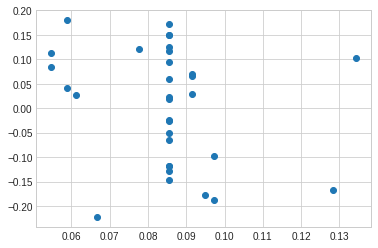

In [137]:
plt.scatter(model.predict(X_test), y_test)                           # garbage
plt.show()

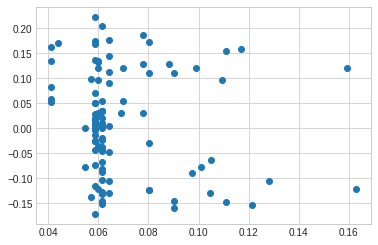

In [138]:
plt.scatter(model.predict(X_train), y_train)
plt.show()

In [139]:
pearsonr(model.predict(X_train), y_train)

(-0.13019353714422432, 0.19667953032582974)

In [140]:
pearsonr(model.predict(X_test), y_test)

(-0.2477392577522165, 0.17159714166439924)

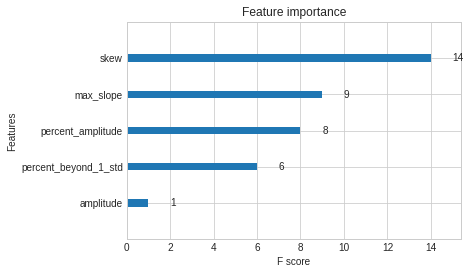

In [141]:
xgb.plot_importance(model)
plt.show()

the problem of above was due to feature generated was not variant

In [142]:
fset_ap.head()

feature,amplitude,percent_beyond_1_std,skew,max_slope,percent_amplitude
0,0.130513,0.454545,-0.155365,0.261026,0.132121
1,0.130513,0.545455,0.051772,0.261026,0.128461
2,0.130513,0.545455,0.037850,0.261026,0.128461
3,0.130513,0.454545,-0.192651,0.261026,0.132121
4,0.130513,0.454545,-0.233966,0.261026,0.132121


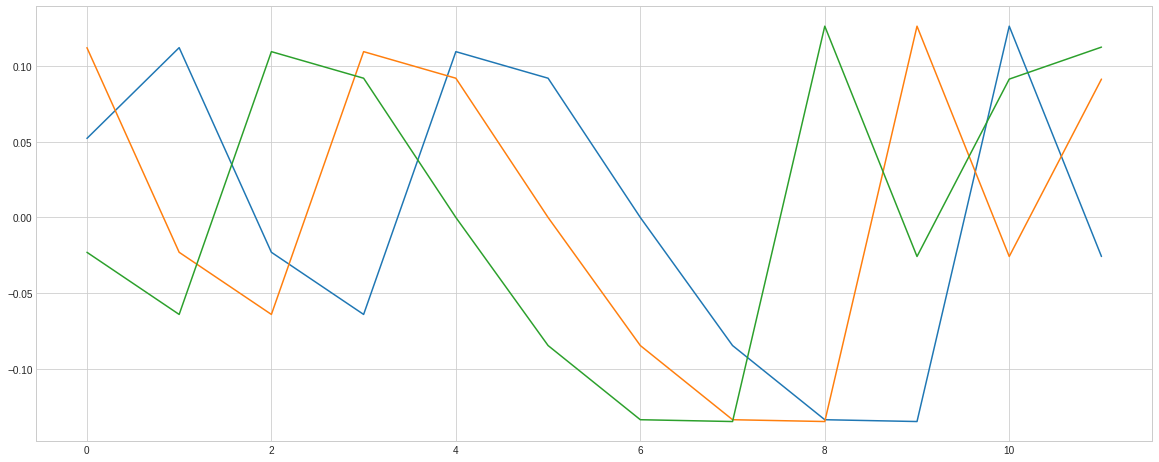

In [143]:
plt.figure(figsize = (20, 8))
plt.plot(vals[0])
plt.plot(vals[1])
plt.plot(vals[2])
plt.show()

positional info was not digest by machine learning, ML only digest magnitude, can see from above figure

In [144]:
# improve and second xgboost with own generated features

In [145]:
vals.shape

(132, 12)

In [146]:
feats = np.zeros( (vals.shape[0], 6), dtype = np.float32)
for i in range(vals.shape[0]):
    feats[i, 0] = np.where(vals[i] == np.max(vals[i]))[0][0]
    feats[i, 1] = np.where(vals[i] == np.min(vals[i]))[0][0]
    feats[i, 2] = feats[i, 0] - feats[i, 1]
    feats[i, 3] = np.max(vals[i][-3:])
    feats[i, 4] = vals[i][-1] - vals[i][-2]
    feats[i, 5] = vals[i][-1] - vals[i][-3]

In [147]:
pd.DataFrame(feats[0:3])

,0,1,2,3,4,5
0,10.0,9.0,1.0,0.126294,-0.152046,0.108980
1,9.0,8.0,1.0,0.126294,0.117102,-0.034944
2,8.0,7.0,1.0,0.112478,0.021128,0.138230


In [148]:
X_train, y_train = feats[:100, :], outcomes[:100]
X_test, y_test   = feats[100:, :], outcomes[100:]

In [149]:
model = xgb.XGBRegressor(n_estimators=20, max_depth=2,
                              random_state=21)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.467759
[1]	validation_0-rmse:0.425064
[2]	validation_0-rmse:0.386848
[3]	validation_0-rmse:0.35241
[4]	validation_0-rmse:0.321675
[5]	validation_0-rmse:0.294493
[6]	validation_0-rmse:0.269802
[7]	validation_0-rmse:0.249599
[8]	validation_0-rmse:0.231346
[9]	validation_0-rmse:0.214722
[10]	validation_0-rmse:0.201125
[11]	validation_0-rmse:0.188284
[12]	validation_0-rmse:0.177724
[13]	validation_0-rmse:0.168863
[14]	validation_0-rmse:0.160408
[15]	validation_0-rmse:0.154006
[16]	validation_0-rmse:0.147978
[17]	validation_0-rmse:0.142052
[18]	validation_0-rmse:0.138151
[19]	validation_0-rmse:0.135491


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=21,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

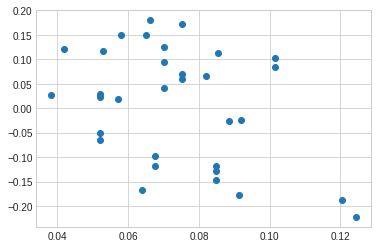

In [150]:
plt.scatter(model.predict(X_test), y_test)

In [151]:
print(pearsonr(model.predict(X_test), y_test))
print(spearmanr(model.predict(X_test), y_test))

(-0.4014127057496292, 0.022779512412242704)
SpearmanrResult(correlation=-0.2716009089025262, pvalue=0.13265640506451284)


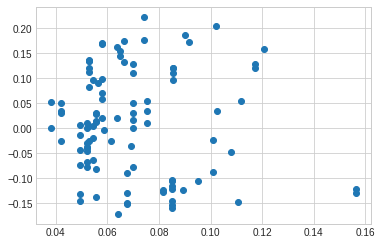

In [152]:
plt.scatter(model.predict(X_train), y_train)

In [153]:
print(pearsonr(model.predict(X_train), y_train))
print(spearmanr(model.predict(X_train), y_train))

(-0.07579547751084295, 0.45355319255555093)
SpearmanrResult(correlation=0.016280197595743676, pvalue=0.8722778702202889)


Now figures tend to be a liitle meaningful, the Spearman correlation is more meaningful when it excludes outliers

## **Clustering by Dynamic Time Warping**

In [154]:
def distDTW(ts1, ts2):
    DTW       = np.full((len(ts1) + 1, len(ts2) + 1), 0, dtype = np.float32)
    DTW[:, 0] = np.inf
    DTW[0, :] = np.inf
    DTW[0, 0] = 0

    for i in range(1, len(ts1) + 1):
        for j in range(1, len(ts2) + 1):
            idx1 = i - 1 
            idx2 = j - 1
            
            dist               = (ts1[idx1] - ts2[idx2])**2
            min_preceding_dist = min(DTW[i-1, j],DTW[i, j-1], DTW[i-1, j-1])

            DTW[i, j] = dist + min_preceding_dist

    return sqrt(DTW[len(ts1), len(ts2)])

# **Deep Learning**

1. Fully connected networks are not timing aware, like ML
2. For time series, RNN is timing aware with temporal axis with hidden states in the background, perhaps more better: GRU & LSTM
3. Do modifications to default CNN, make it to Casusal CNN, then it is time aware and can be used to TS analysis, it is more successful when doing classification than foreacsting
4. LSTNet: mixed with LSTM & CNN to accommodate more complex TS settings and statistical components(e.g., AR), such as trend and seasonality and all other stuff
5. Most competitive modern TS models in competitions are incorporated with traditional analysis, ML method(xgboost) to find important features and Deep Learning algos

In [4]:
file_4 = folder / "electricity.diff.txt"
print(file_4)

/home/edison/Desktop/2019_Modern_TimeSeriesAnalysis/Data/electricity.diff.txt


In [5]:
elec = pd.read_csv(file_4)

In [10]:
elec

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,4,23,78,141,77,307,0,262,45,75,...,129,80,15100.0,-76,1615,17,9,619,71,673
1,3,4,0,4,-20,-123,0,-77,-1,-40,...,12,-22,1400.0,-358,-46,-1,-4,16,-35,-71
2,-1,-4,0,-117,-59,-395,-5,-192,-91,-89,...,-16,-139,-2100.0,-63,-206,1,-4,-878,-23,-29
3,2,-1,0,-97,-23,-198,-8,-100,7,-32,...,6,-12,-3200.0,-106,-67,10,1,63,-4,-14
4,-2,1,-125,-6,-12,-6,2,-7,-2,-2,...,-5,110,-4300.0,143,-750,-11,-1,-128,-6,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26298,0,-1,-4,14,33,91,-4,-55,48,23,...,-171,-226,-13400.0,-2519,-6817,-201,-5,-270,-64,-107
26299,0,-13,0,-95,-13,-224,-4,-147,-38,-24,...,-523,-253,-7700.0,-3105,-1456,-22,-1,-364,276,-18
26300,1,-10,0,-99,-25,-84,1,-186,-61,-44,...,-436,-25,-4500.0,-210,-3046,0,-2,358,183,-105
26301,-2,-1,0,-4,3,-21,0,-70,-20,9,...,-105,-84,-12400.0,-56,-408,-43,15,759,162,69


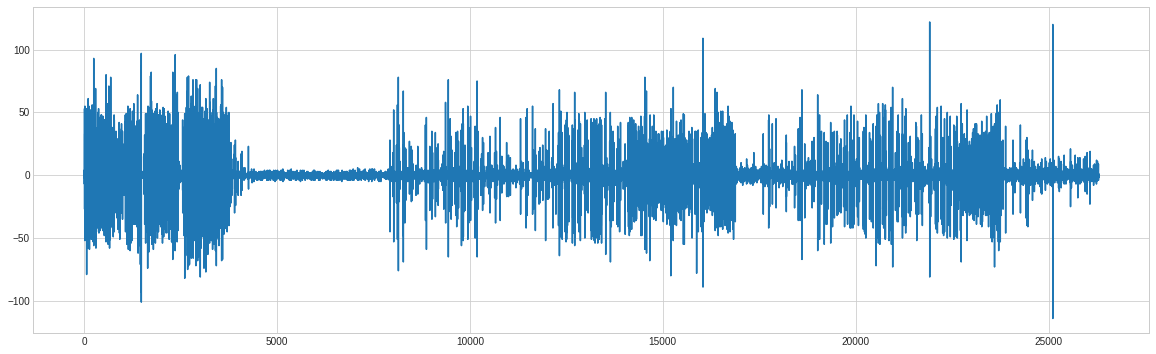

In [11]:
plt.figure(figsize = (20, 6))
plt.plot(elec.V1)
plt.show()

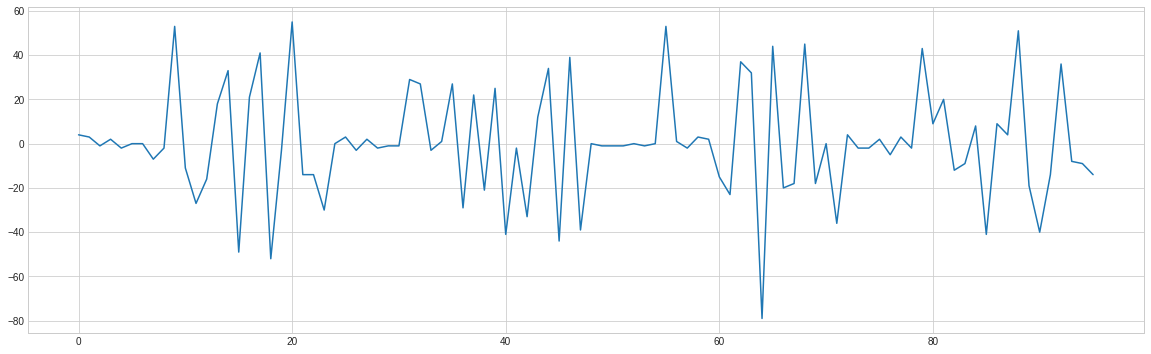

In [12]:
plt.figure(figsize = (20, 6))
plt.plot(elec.V1[:96])
plt.show()

### Define models:

In [9]:
################
## MODELS ##
################

def fc_model(iter_train, input_feature_shape, X, Y,
             win, sz_filt, n_filter, drop, seasonal_period):
    output = mx.sym.FullyConnected(data=X, num_hidden=20)
    output = mx.sym.Activation(output, act_type = 'relu')
    output = mx.sym.FullyConnected(data=output, num_hidden=10)
    output = mx.sym.Activation(output, act_type = 'relu')
    output = mx.sym.FullyConnected(data=output, num_hidden=321)
    
    loss_grad = mx.sym.LinearRegressionOutput(data=output, label=Y)
    return (loss_grad,
            [v.name for v in iter_train.provide_data],
            [v.name for v in iter_train.provide_label])    
    
def cnn_model(iter_train, input_feature_shape, X, Y,
              win, sz_filt, n_filter, drop, seasonal_period):
    conv_input = mx.sym.reshape(data=X, shape=(0, 1, win, -1)) 
    ## Convolution expects 4d input (N x channel x height x width)
    ## in our case channel = 1 (similar to a black and white image
    ## height = time and width = channels slash electric locations
    
    cnn_output = mx.sym.Convolution(data=conv_input,
                                    kernel=(sz_filt,
                                            input_feature_shape[2]),
                                    num_filter=n_filter)
    cnn_output = mx.sym.Activation(data=cnn_output, act_type='relu')
    cnn_output = mx.sym.reshape(mx.sym.transpose(data=cnn_output,
                                                 axes=(0, 2, 1, 3)),
                                shape=(0, 0, 0)) 
    cnn_output = mx.sym.Dropout(cnn_output, p=drop)
        
    output = mx.sym.FullyConnected(data=cnn_output,
                                   num_hidden=input_feature_shape[2])
    loss_grad = mx.sym.LinearRegressionOutput(data=output, label=Y)
    return (loss_grad,
            [v.name for v in iter_train.provide_data],
            [v.name for v in iter_train.provide_label])    

    
def rnn_model(iter_train, input_feature_shape, X, Y,
              win, sz_filt, n_filter, drop, seasonal_period):
    rnn_cells = mx.rnn.SequentialRNNCell()
    rnn_cells.add(mx.rnn.GRUCell(num_hidden=RNN_UNITS))
    rnn_cells.add(mx.rnn.DropoutCell(drop))
    outputs, _ = rnn_cells.unroll(length=win, inputs=X, merge_outputs=False)
    rnn_output = outputs[-1] # only take value from final unrolled cell for use later
    
    output = mx.sym.FullyConnected(data=rnn_output, num_hidden=input_feature_shape[2])
    loss_grad = mx.sym.LinearRegressionOutput(data=output, label=Y)
    return (loss_grad,
            [v.name for v in iter_train.provide_data],
            [v.name for v in iter_train.provide_label])    

## simplifications to
## https://github.com/apache/incubator-mxnet/blob/master/example/multivariate_time_series/src/lstnet.py
def simple_lstnet_model(iter_train,  input_feature_shape, X, Y,
                        win, sz_filt, n_filter, drop, seasonal_period):
    ## must be 4d or 5d to use padding functionality
    conv_input = mx.sym.reshape(data=X, shape=(0, 1, win, -1)) 

    ## convolutional element
    ## we add padding at the end of the time win
    cnn_output = mx.sym.pad(data=conv_input,
                            mode="constant",
                            constant_value=0,
                            pad_width=(0, 0,
                                       0, 0,
                                       0, sz_filt - 1, 
                                       0, 0))
    cnn_output = mx.sym.Convolution(data=cnn_output,
                                    kernel=(sz_filt,
                                            input_feature_shape[2]),
                                    num_filter=n_filter)
    cnn_output = mx.sym.Activation(data=cnn_output, act_type='relu')
    cnn_output = mx.sym.reshape(mx.sym.transpose(data=cnn_output,
                                                 axes=(0, 2, 1, 3)),
                                shape=(0, 0, 0))
    cnn_output = mx.sym.Dropout(cnn_output, p=drop)

    ## recurrent element
    stacked_rnn_cells = mx.rnn.SequentialRNNCell()
    stacked_rnn_cells.add(mx.rnn.GRUCell(num_hidden=RNN_UNITS))
    outputs, _ = stacked_rnn_cells.unroll(length=win,
                                          inputs=cnn_output,
                                          merge_outputs=False)
    rnn_output = outputs[-1] # only take value from final unrolled cell for use later
    n_outputs = input_feature_shape[2]
    cnn_rnn_model = mx.sym.FullyConnected(data=rnn_output,
                                          num_hidden=n_outputs)

    ## ar element
    ar_outputs = []
    for i in list(range(input_feature_shape[2])):
        ar_series = mx.sym.slice_axis(data=X,
                                      axis=2,
                                      begin=i,
                                      end=i+1)
        fc_ar = mx.sym.FullyConnected(data=ar_series, num_hidden=1)
        ar_outputs.append(fc_ar)
    ar_model = mx.sym.concat(*ar_outputs, dim=1)

    output = cnn_rnn_model + ar_model
    loss_grad = mx.sym.LinearRegressionOutput(data=output, label=Y)
    return (loss_grad,
            [v.name for v in iter_train.provide_data],
            [v.name for v in iter_train.provide_label])